In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

#change filename here if necessary
filename = 'Desktop\AAPL (3).csv'

df = pd.read_csv(filename)

df.sort_values('Date')

df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
4517,2018-08-31,226.509995,228.869995,226.000000,227.630005,227.630005,43340100
4518,2018-09-04,228.410004,229.179993,226.630005,228.360001,228.360001,27390100
4519,2018-09-05,228.990005,229.669998,225.100006,226.869995,226.869995,33333000
4520,2018-09-06,226.229996,227.350006,221.300003,223.100006,223.100006,34290000
4521,2018-09-07,221.850006,225.369995,220.710007,221.300003,221.300003,37619800
4522,2018-09-10,220.949997,221.850006,216.470001,218.330002,218.330002,39516500
4523,2018-09-11,218.009995,224.300003,216.559998,223.850006,223.850006,35749000
4524,2018-09-12,224.940002,225.000000,219.839996,221.070007,221.070007,49278700
4525,2018-09-13,223.520004,228.350006,222.570007,226.410004,226.410004,41706400
4526,2018-09-14,225.750000,226.839996,222.520004,223.839996,223.839996,31902700


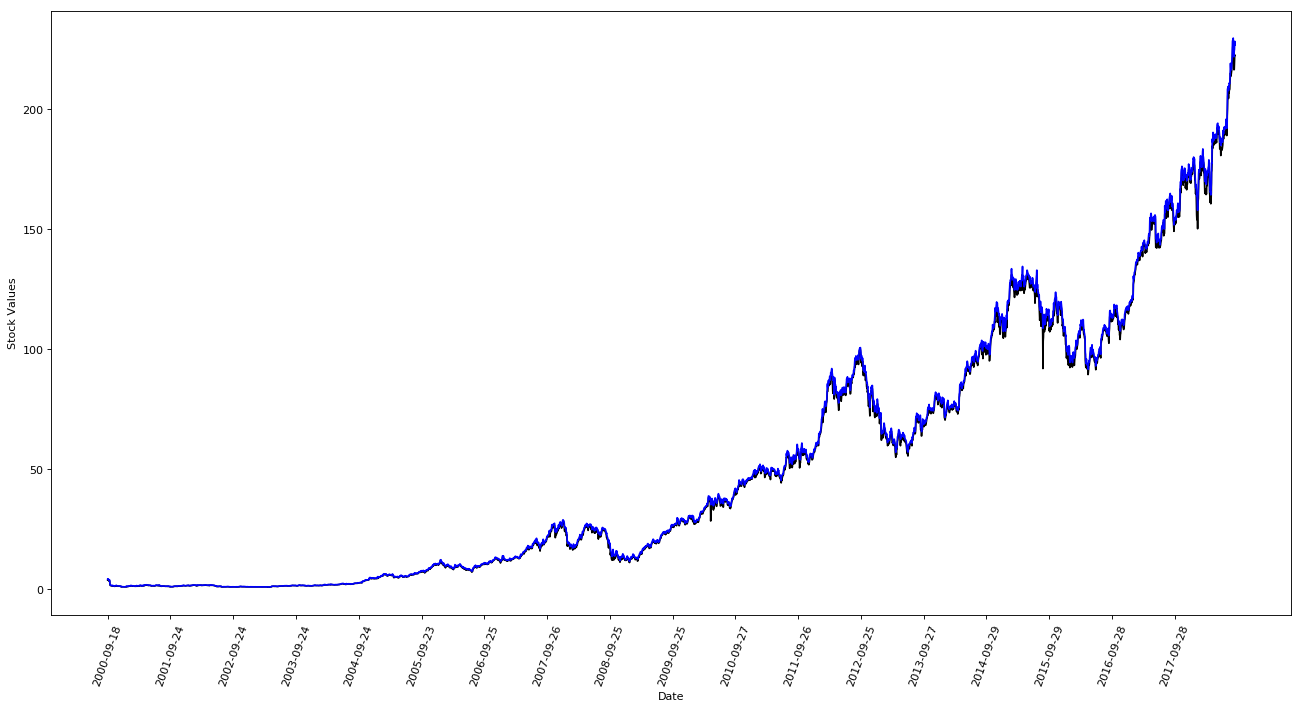

In [2]:
#viewing plot of AAPL data
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['Date'], df['Low'], color = 'black', label = 'Low')
plt.plot(df['Date'], df['High'], color = 'blue', label = 'High')
plt.xticks(df['Date'].loc[::252],rotation=70)
plt.xlabel('Date')
plt.ylabel('Stock Values')
plt.show()

In [3]:
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
open_prices = df.loc[:,'Open'].as_matrix()
close_prices = df.loc[:,'Close'].as_matrix()
OHLC_mean = (high_prices+low_prices+open_prices+close_prices)/4.0

print(OHLC_mean)

[  4.13783425   4.263393     4.29380375 ... 222.71250125 225.21250525
 224.737499  ]


C:\Users\Yi Rong\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\Yi Rong\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Yi Rong\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Yi Rong\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [7]:
scaler = MinMaxScaler()
OHLC_mean_scaled = OHLC_mean.reshape(-1,1)
OHLC_mean_scaled = scaler.fit_transform(OHLC_mean_scaled)
train_data = OHLC_mean_scaled[:4400]
test_data = OHLC_mean_scaled[4400:]


In [8]:
all_OHLC_data = np.concatenate([train_data,test_data],axis=0)

In [9]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.01410179 0.00395793 0.08401794 0.21209416 0.4392003 ]

	Output: [0.01199698 0.00393749 0.08401794 0.20813623 0.44583508]


Unrolled index 1
	Inputs:  [0.01465439 0.00393749 0.08491233 0.20671842 0.44276527]

	Output: [0.01397162 0.00389034 0.08886711 0.2067923  0.44276527]


Unrolled index 2
	Inputs:  [0.01478824 0.00389034 0.08416098 0.2067923  0.44583508]

	Output: [0.01246362 0.00440276 0.08552535 0.21053016 0.43690068]


Unrolled index 3
	Inputs:  [0.01397162 0.00420628 0.08552535 0.20589004 0.43690068]

	Output: [0.01174155 0.00440276 0.09021104 0.20813623 0.4421491 ]


Unrolled index 4
	Inputs:  [0.01199698 0.00440276 0.08886711 0.20813623 0.441775  ]

	Output: [0.01246362 0.00457252 0.09021104 0.21149842 0.44340345]


In [10]:
D = 1 # Dimensionality of the data. 
num_unrollings = 100 # Number of time steps you look into the future.
batch_size = 100 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

In [11]:
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [12]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [13]:
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of 
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [14]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [15]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [16]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 3 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings) 

x_axis_seq = []

# Points you start our test predictions from
test_points_seq = np.arange(4400,4526,3).tolist() 

for ep in range(epochs):       
    
    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):
        
        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
    
    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
      
      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))
      
      train_mse_ot.append(average_loss)
            
      average_loss = 0 # reset loss
      
      predictions_seq = []
      
      mse_test_loss_seq = []
      
      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []
        
        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]
        
        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_OHLC_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)
        
        feed_dict = {}
        
        current_price = all_OHLC_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        
        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)
        
          our_predictions.append(np.asscalar(pred))
        
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_OHLC_data[w_i+pred_i])**2
        
        session.run(reset_sample_states)
        
        predictions_seq.append(np.array(our_predictions))
        
        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)
        
        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)
        
      current_test_mse = np.mean(mse_test_loss_seq)
      
      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0
      
      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

Initialized
Average loss at step 1: 0.799513
	Test MSE: 0.00084
	Finished Predictions
Average loss at step 2: 0.098158
	Test MSE: 0.00099
	Finished Predictions
Average loss at step 3: 0.077495
	Test MSE: 0.00122
	Finished Predictions
Average loss at step 4: 0.066684
	Decreasing learning rate by 0.5
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 5: 0.063864
	Test MSE: 0.00151
	Finished Predictions
Average loss at step 6: 0.061555
	Test MSE: 0.00122
	Finished Predictions
Average loss at step 7: 0.057653
	Decreasing learning rate by 0.5
	Test MSE: 0.00141
	Finished Predictions
Average loss at step 8: 0.055941
	Test MSE: 0.00119
	Finished Predictions
Average loss at step 9: 0.056718
	Test MSE: 0.00130
	Finished Predictions
Average loss at step 10: 0.055830
	Decreasing learning rate by 0.5
	Test MSE: 0.00124
	Finished Predictions
Average loss at step 11: 0.055168
	Test MSE: 0.00138
	Finished Predictions
Average loss at step 12: 0.053318
	Test MSE: 0.00138
	Finished Prediction

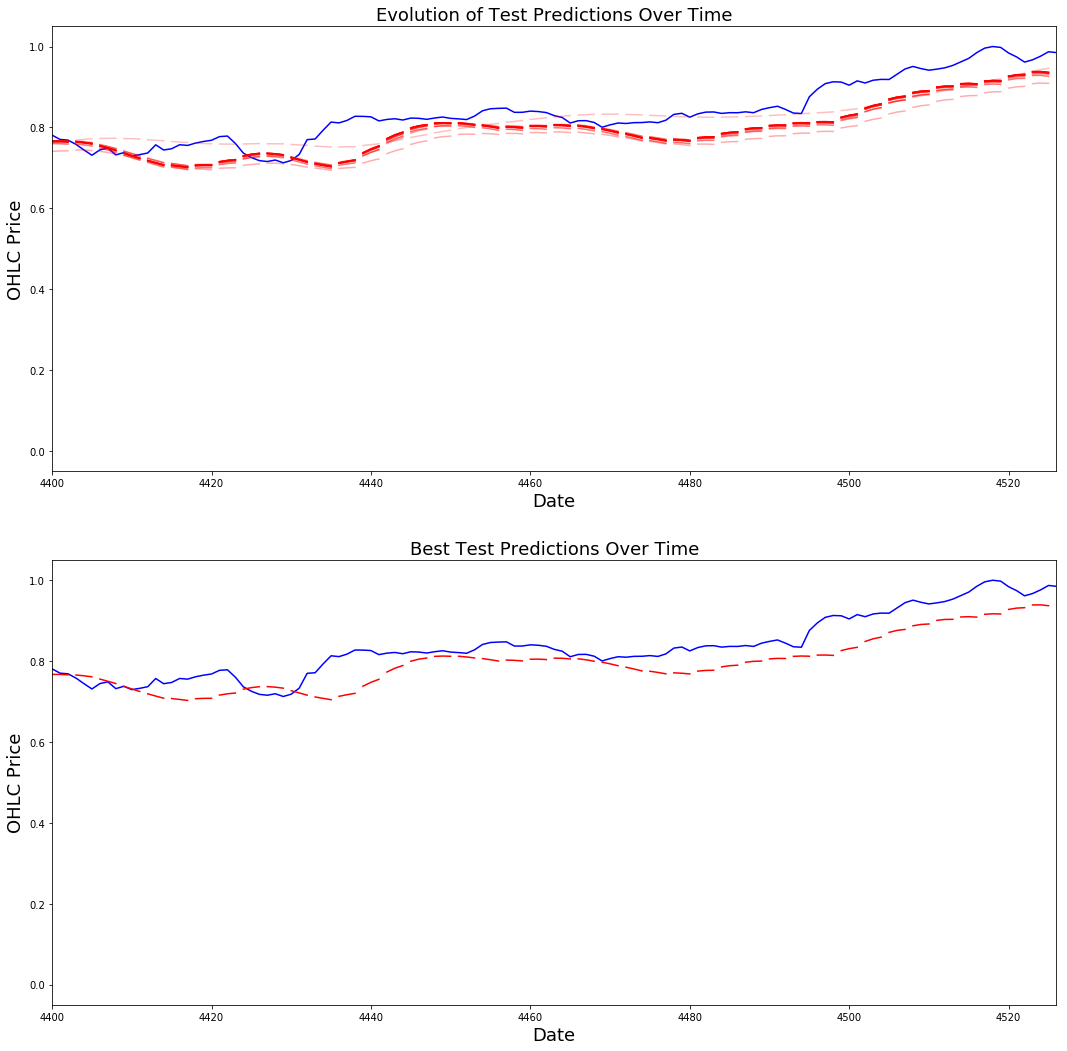

In [18]:
best_prediction_epoch = 23 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_OHLC_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('OHLC Price',fontsize=18)
plt.xlim(4400,4526)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_OHLC_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')
    
plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('OHLC Price',fontsize=18)
plt.xlim(4400,4526)
plt.show()

In [20]:
print (predictions_over_time[best_prediction_epoch])


[array([0.76720589, 0.76706684, 0.76611012]), array([0.76569277, 0.76373523, 0.76109874]), array([0.75554824, 0.75017136, 0.74450499]), array([0.73752111, 0.73116565, 0.72497922]), array([0.71912462, 0.71357703, 0.70823538]), array([0.70748991, 0.70518953, 0.70275503]), array([0.70701027, 0.70790339, 0.70806986]), array([0.7159794 , 0.71914703, 0.72109812]), array([0.73060924, 0.73441702, 0.73668158]), array([0.73696297, 0.73559809, 0.73309767]), array([0.72677904, 0.72135395, 0.71577209]), array([0.71139824, 0.70784461, 0.70456648]), array([0.71297216, 0.71693778, 0.72026569]), array([0.73801965, 0.74753869, 0.75504422]), array([0.77304125, 0.78238219, 0.7890656 ]), array([0.79975337, 0.80480951, 0.80765408]), array([0.81172174, 0.81253368, 0.81192672]), array([0.81204396, 0.81032622, 0.80777669]), array([0.80621988, 0.8034811 , 0.80018598]), array([0.802625  , 0.80193102, 0.80051267]), array([0.80470073, 0.80485648, 0.80387551]), array([0.80727834, 0.80698675, 0.8054955 ]), array([0.

In [22]:
predictions = []
for i in predictions_over_time[best_prediction_epoch]:
    for x in i:
        predictions.append(x)
print (predictions)

[0.7672058939933777, 0.7670668363571167, 0.7661101222038269, 0.7656927704811096, 0.7637352347373962, 0.7610987424850464, 0.7555482387542725, 0.7501713633537292, 0.744504988193512, 0.7375211119651794, 0.7311656475067139, 0.7249792218208313, 0.7191246151924133, 0.7135770320892334, 0.7082353830337524, 0.7074899077415466, 0.7051895260810852, 0.7027550339698792, 0.7070102691650391, 0.7079033851623535, 0.7080698609352112, 0.7159793972969055, 0.7191470265388489, 0.7210981249809265, 0.7306092381477356, 0.7344170212745667, 0.7366815805435181, 0.7369629740715027, 0.735598087310791, 0.7330976724624634, 0.726779043674469, 0.7213539481163025, 0.7157720923423767, 0.7113982439041138, 0.707844614982605, 0.704566478729248, 0.7129721641540527, 0.716937780380249, 0.7202656865119934, 0.7380196452140808, 0.747538685798645, 0.7550442218780518, 0.7730412483215332, 0.7823821902275085, 0.7890655994415283, 0.7997533679008484, 0.8048095107078552, 0.807654082775116, 0.8117217421531677, 0.8125336766242981, 0.81192

In [26]:
true_values = OHLC_mean[4400:4526]
counter = 0;
for i in range(len(true_values)-1):
    if true_values[i+1] > true_values[i] and predictions[i+1] > predictions[i]:
        counter = counter + 1
    elif true_values[i+1] < true_values[i] and predictions[i+1] < predictions[i]:
        counter = counter + 1
print (counter)
print(counter/(len(predictions)-1))

64
0.512
